In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json
from keras.preprocessing.image import img_to_array
import sklearn.metrics

In [3]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    
    dcm = pydicom.dcmread(filename)

    print('Load file {} ...'.format(filename))
    print('Patient Position: ', dcm.PatientPosition)
    print('Body Part Examined: ', dcm.BodyPartExamined)
    print('Study Description: ', dcm.StudyDescription)
    print('Image type: ', dcm.Modality)
    
    if (dcm.BodyPartExamined !='CHEST') or (dcm.Modality !='DX') or (dcm.PatientPosition not in ['PA', 'AP']):
        
        print('Unable to process this file')
        img = None

    else:
        img = dcm.pixel_array
        print('File processed correctly')

    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size = (1,224,224,3)):
    # todo
    img=img/255.0  
    proc_img=(img-img_mean)/img_std 
    proc_img = np.zeros((224,224,3))
    proc_img = np.resize(proc_img,img_size)
    
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # todo
    # load json file
    file = open(model_path)
    # read the json file
    json_to_model = file.read()
    model = model_from_json(json_to_model)
    # load weights
    model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    # todo
    result = model.predict(img)
    predict=result[0]
    prediction='No pneumonia'
    if(predict>thresh):
         prediction='Pneumonia'
    
    return prediction

In [4]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'pneumonia_model_json.json'
weight_path = 'xray_class_my_model.best.hdf5'

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
#img_mean = # loads the mean image value they used during training preprocessing
#img_std = # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path)
thresh = 0.4 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
predictions = []
for i in test_dicoms:
    
    img = check_dicom(i)
    
    if img is None:
        predictions.append('Unable')
        continue
    
    img_mean = np.mean(img)
    img_std = np.std(img)
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    predictions.append(pred)
    print(pred)

Load file test1.dcm ...
Patient Position:  PA
Body Part Examined:  CHEST
Study Description:  No Finding
Image type:  DX
File processed correctly
Pneumonia
Load file test2.dcm ...
Patient Position:  AP
Body Part Examined:  CHEST
Study Description:  Cardiomegaly
Image type:  DX
File processed correctly
Pneumonia
Load file test3.dcm ...
Patient Position:  AP
Body Part Examined:  CHEST
Study Description:  Effusion
Image type:  DX
File processed correctly
Pneumonia
Load file test4.dcm ...
Patient Position:  PA
Body Part Examined:  RIBCAGE
Study Description:  No Finding
Image type:  DX
Unable to process this file
Load file test5.dcm ...
Patient Position:  PA
Body Part Examined:  CHEST
Study Description:  No Finding
Image type:  CT
Unable to process this file
Load file test6.dcm ...
Patient Position:  XX
Body Part Examined:  CHEST
Study Description:  No Finding
Image type:  DX
Unable to process this file


In [6]:
predictions

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Unable', 'Unable', 'Unable']

In [7]:
all_data = []

for dicom in test_dicoms: 
    dcm = pydicom.dcmread(dicom)
    fields = [dcm.PatientID, dcm.Modality, dcm.BodyPartExamined, dcm.PatientPosition, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)

In [8]:
mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','Modality','Body Part', 'Patient Position','Findings','Rows','Columns'])

In [9]:
mydata['algorithm_output'] = predictions

In [10]:
mydata

,PatientID,Modality,Body Part,Patient Position,Findings,Rows,Columns,algorithm_output
0,2,DX,CHEST,PA,No Finding,1024,1024,Pneumonia
1,1,DX,CHEST,AP,Cardiomegaly,1024,1024,Pneumonia
2,61,DX,CHEST,AP,Effusion,1024,1024,Pneumonia
3,2,DX,RIBCAGE,PA,No Finding,1024,1024,Unable
4,2,CT,CHEST,PA,No Finding,1024,1024,Unable
5,2,DX,CHEST,XX,No Finding,1024,1024,Unable


In [11]:
numeric_output = mydata.algorithm_output.copy()
numeric_output = numeric_output.replace('No pneumonia', 0).replace('Pneumonia', 1)

In [12]:
mydata['numeric_output'] = numeric_output

In [13]:
mydata

,PatientID,Modality,Body Part,Patient Position,Findings,Rows,Columns,algorithm_output,numeric_output
0,2,DX,CHEST,PA,No Finding,1024,1024,Pneumonia,1
1,1,DX,CHEST,AP,Cardiomegaly,1024,1024,Pneumonia,1
2,61,DX,CHEST,AP,Effusion,1024,1024,Pneumonia,1
3,2,DX,RIBCAGE,PA,No Finding,1024,1024,Unable,Unable
4,2,CT,CHEST,PA,No Finding,1024,1024,Unable,Unable
5,2,DX,CHEST,XX,No Finding,1024,1024,Unable,Unable


## Intended use: 

In [16]:
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')
performances = pd.read_csv('model_performances.csv')

In [18]:
performances.algorithm_output.value_counts()

1    1430
Name: algorithm_output, dtype: int64

2 90


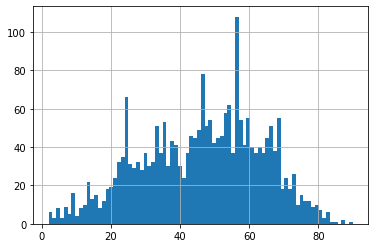

In [7]:
train['Patient Age'].hist(bins = 80)
print(train['Patient Age'].min(), train['Patient Age'].max())

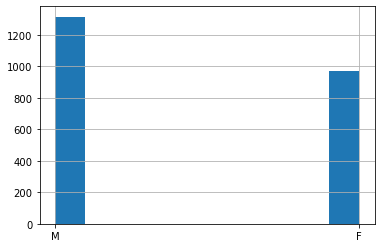

In [22]:
train['Patient Gender'].hist()

So, this model is trained over patient (both female and male) images ranging from 2 - 90 years 

Now, let's look at the algorithm's performance in the presence of the other diseases:

In [99]:
test

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_String
0,46927,00011966_016.png,Edema|Infiltration|Pneumonia,16,11966,22,M,AP,2500,2048,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
1,18935,00005032_000.png,Pneumonia,0,5032,53,M,PA,2500,2048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
2,85978,00021201_088.png,Edema|Effusion|Pneumonia,88,21201,66,M,AP,3056,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
3,97684,00025787_007.png,Edema|Infiltration|Pneumonia,7,25787,27,M,AP,3056,2544,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
4,55831,00013968_007.png,Edema|Pneumonia,7,13968,26,M,AP,2500,2048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,92342,00023068_035.png,No Finding,35,23068,72,F,AP,3056,2544,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Non-pneumonia
1426,12721,00003337_006.png,Pleural_Thickening,6,3337,68,F,AP,2048,2500,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Non-pneumonia
1427,4863,00001301_027.png,Infiltration,27,1301,57,F,AP,2500,2048,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-pneumonia
1428,20813,00005563_001.png,Nodule,1,5563,46,F,AP,2500,2048,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Non-pneumonia
